# Training an Fourier Neural Operator (FNO) on Darcy-Flow with `neuraloperator`

- https://github.com/neuraloperator/neuraloperator

In [ ]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from neuralop.layers.embeddings import GridEmbedding2D

device = 'cpu'

Let’s load the small Darcy-flow dataset.

In [ ]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [ ]:
train_dataset = train_loader.dataset

## Visualizing the data

16
Testing samples for res 16 have shape torch.Size([1, 16, 16])
32
Testing samples for res 32 have shape torch.Size([1, 32, 32])
Training samples have shape torch.Size([16, 16])


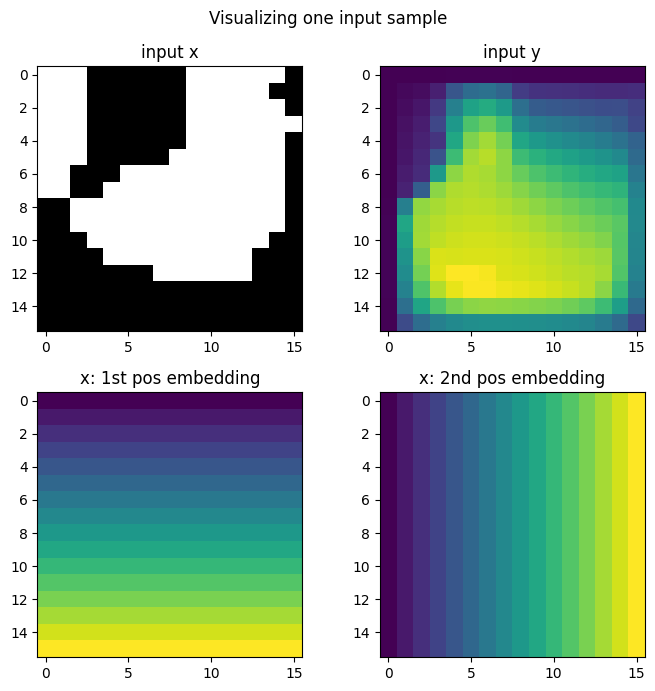

In [ ]:
for res, test_loader in test_loaders.items():
    print(res)
    # Get first batch
    batch = next(iter(test_loader))
    x = batch['x']
    y = batch['y']

    print(f'Testing samples for res {res} have shape {x.shape[1:]}')


data = train_dataset[0]
x = data['x']
y = data['y']

print(f'Training samples have shape {x.shape[1:]}')


# Which sample to view
index = 0

data = train_dataset[index]
data = data_processor.preprocess(data, batched=False)

# The first step of the default FNO model is a grid-based
# positional embedding. We will add it manually here to
# visualize the channels appended by this embedding.
positional_embedding = GridEmbedding2D(in_channels=1)
# at train time, data will be collated with a batch dim.
# we create a batch dim to pass into the embedding, then re-squeeze
x = positional_embedding(data['x'].unsqueeze(0)).squeeze(0)
y = data['y']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(y.squeeze())
ax.set_title('input y')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')
fig.suptitle('Visualizing one input sample', y=0.98)
plt.tight_layout()
plt.show()

## Model

We create a simple FNO model

In [ ]:
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')


Our model has 1192801 parameters.


## Training setup

Create the optimizer


In [ ]:
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Then create the losses

In [ ]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

## Training the model

In [ ]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

Create the trainer:

In [ ]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

Then train the model on our small Darcy-Flow dataset:

In [ ]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=1.29, avg_loss=0.6203, train_err=19.3845
Eval: 16_h1=0.4336, 16_l2=0.2856, 32_h1=0.5683, 32_l2=0.2999
[3] time=1.26, avg_loss=0.2190, train_err=6.8429
Eval: 16_h1=0.2148, 16_l2=0.1537, 32_h1=0.4877, 32_l2=0.1901
[6] time=1.31, avg_loss=0.1802, train_err=5.6306
Eval: 16_h1=0.2128, 16_l2=0.1462, 32_h1=0.4819, 32_l2=0.1842
[9] time=1.28, avg_loss=0.1637, train_err=5.1161
Eval: 16_h1=0.2141, 16_l2=0.1393, 32_h1=0.5137, 32_l2=0.1740
[12] time=1.29, avg_loss=0.1443, train_err=4.5109
Eval: 16_h1=0.2110, 16_l2=0.1283, 32_h1=0.5429, 32_l2=0.1697
[15] time=1.27, avg_loss=0.1244, train_err=3.8886
Eval: 16_h1=0.2146, 16_l2=0.1288, 32_h1=0.4983, 32_l2=0.1661
[18] time=1.28, avg_loss=0.1144, train_err=3.5762
Eval: 16_h1=0.2205, 16_l2=0.1414, 32_h1=0.5029, 32_l2=0.1789


{'train_err': 3.1807391438633204,
 'avg_loss': 0.10178365260362625,
 'avg_lasso_loss': None,
 'epoch_train_time': 1.2483766000004834}

## Visualizing predictions

Let’s take a look at what our model’s predicted outputs look like. Again note that in this example, we train on a very small resolution for a very small number of epochs. In practice, we would train at a larger resolution, on many more samples.

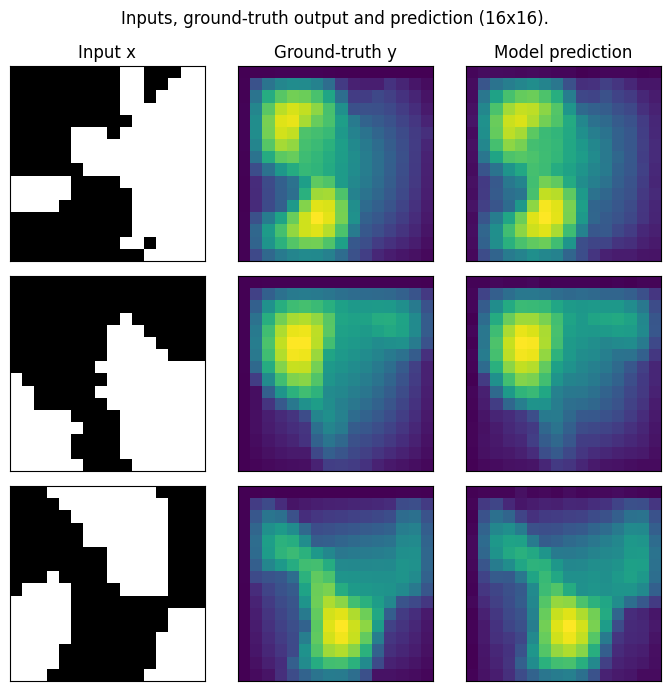

In [ ]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
plt.show()

## Zero-shot super-evaluation

In addition to training and making predictions on the same input size, the FNO’s invariance to the discretization of input data means we can natively make predictions on higher-resolution inputs and get higher-resolution outputs.

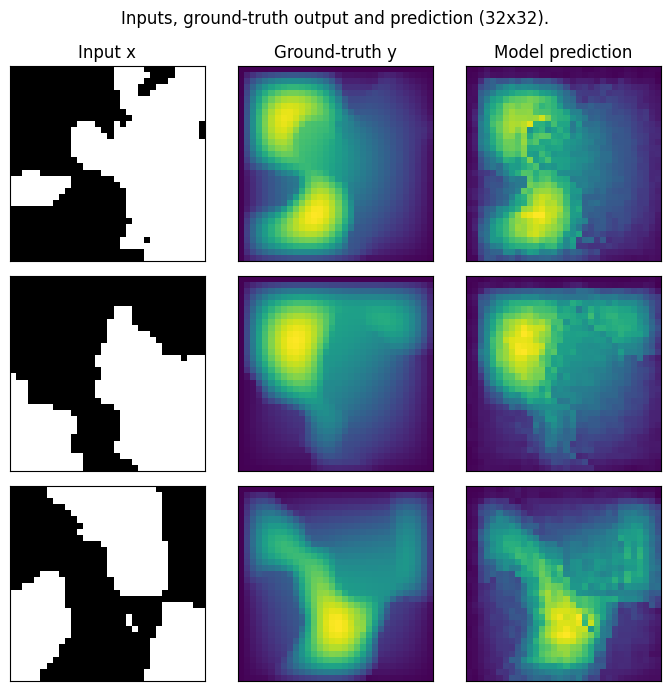

In [ ]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
plt.show()

We only trained the model on data at a resolution of 16x16, and with no modifications or special prompting, we were able to perform inference on higher-resolution input data and get higher-resolution predictions! In practice, we often want to evaluate neural operators at multiple resolutions to track a model’s zero-shot super-evaluation performance throughout training. That’s why many of our datasets, including the small Darcy-flow we showcased, are parameterized with a list of test_resolutions to choose from.

However, as you can see, these predictions are noisier than we would expect for a model evaluated at the same resolution at which it was trained. Leveraging the FNO’s discretization-invariance, there are other ways to scale the outputs of the FNO to train a true super-resolution capability.